To see on GitHub, visit: https://github.com/PeterKinder/CNN-Cancer-Detection

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.models as models

# Problem and Data Description

The problem is to identify metastatic cancer in smaller image patches taken from larger pathology scans. The first step was to read in the labels to inspect the data that was provided.

In [2]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
print('Total training samples:', train_labels.shape[0])

Total training samples: 220025


In [4]:
train_file_path = 'data/train/'
train_file_names = os.listdir(train_file_path)
print('Sample file name:', train_file_names[0])

Sample file name: 00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif


As can be seen, the labels dataset consists of the labels (with 1 for cancer and 0 for no cancer) and the filenames associated with the image for each label. There were a total of 220,025 samples provided and the images were provided in tif format. 

# Exploratory Data Analysis

After reviewing this, a subsample of the images were explored to see what exactly they looked like.

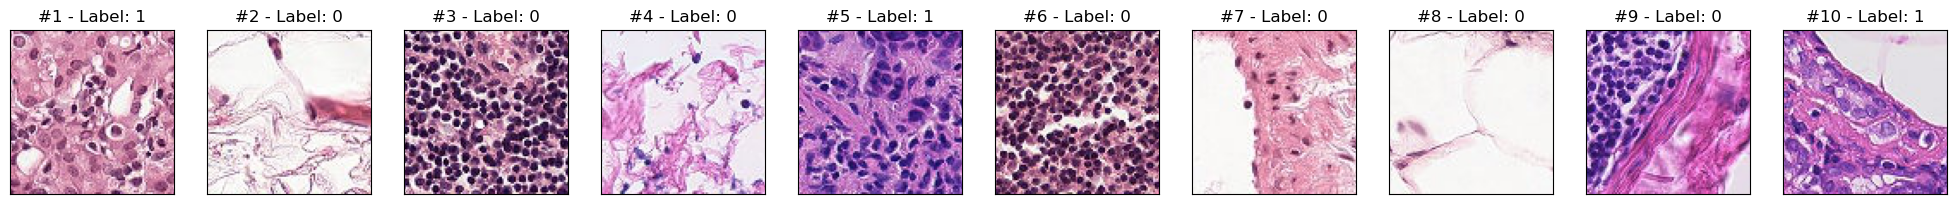

In [5]:
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(train_file_path + train_file_names[i])
    plt.imshow(im)
    label = train_labels.loc[train_labels['id'] == train_file_names[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

As can be observed, even the small subsample shows a relative diverse set of images. However, since I am not a domain expert, there is not much value I can derive from this. The next step was to inspect the distribution of the labels.

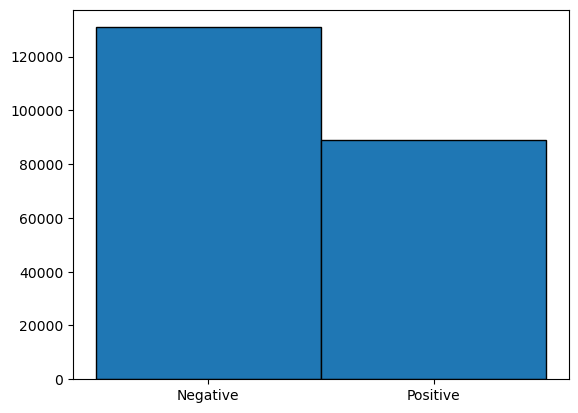

In [6]:
plt.hist(train_labels['label'], bins=2, edgecolor='black')
plt.xticks([0.25, 0.75], ['Negative', 'Positive'])
plt.show()

The distribution of the labels was clearly and significantly unbalanced. So, to avoid a bias being reflected in the model, it was decided to take an equal size sample of each label to balance the labels. From eyeballing it, it appears there were at least 80,000 positive labels, so 80,000 sample of positive and negative sample each were taken without replacement.

In [7]:
sample_size = 80000
negative_sample = train_labels[train_labels['label'] == 0].sample(sample_size, random_state=22)
positive_sample = train_labels[train_labels['label'] == 1].sample(sample_size, random_state=22)
training_sample = pd.concat([negative_sample, positive_sample])
training_sample

,id,label
84132,7b69df27584c78b6e9d9e7ca573372b6f7f7dab9,0
110668,a59a06ab7d843cdf3b1138989f5db18827c7c660,0
213835,525fa1af3df9cdf0fe9ffa932cd5fef656cd778a,0
31222,7ebcd6c14757971e90fb8c9c6259165134c44744,0
39190,31ba2fc61e39c3d6dc938d3947ba5f003a0174a3,0
...,...,...
34377,52a9154a76d015cb6562240720228d459bab2fc6,1
38878,4e4c18dbec45419d3ac51acbcc28761d79f38119,1
26761,8d828f7000b20f2c8e20ae2309b48be7a9f4ab32,1
136522,f5edd6ec2bbc0f2abb971bc742f6ac62b56a9f33,1


With a balanced dataset, the dataset was split into train and validation sets with a 80/20 split. 

In [8]:
train_sample, valid_sample = train_test_split(training_sample, test_size=0.2, random_state=22, shuffle=True)

In [9]:
train_sample

,id,label
173908,046132f4728679204becbdad3bb0ab7fdb57ff35,1
103191,4bda76792acb21e33691819b115b0b4a79e8c132,1
203654,066a9808f24230b032d08197c59fea74c5e09683,1
207131,fc030cb729b9eb34fb789b6df5c92bccc1c8d628,1
19730,ad2628cd8df38c7b82df83f57a72528ca5105152,1
...,...,...
12131,59a95d82cecb72300ad14b788eed8d8d6d49a3dc,1
191666,9d12f7c25649d3ff6085a73a7660aed24c3f0297,0
39787,7d48a120342c24ee014c4b69999ed08b8a749171,1
136212,71e1a837098afff009d7c00a19515210035a84ee,0


In [10]:
valid_sample

,id,label
197249,63585bab8474dd23e5dc8801df9f74769b62c7c3,0
22040,f5899b925cea2912f3097555b936b3e3008c35dd,0
168697,fb4cda7598123ab094d0441f20a02ee9590605c7,0
184190,c8fb0867ae0a9eab430231a5f5c0eb49e58cc0ba,0
80111,813cb929afd4339d8e731bcaef86c8413a1281cb,0
...,...,...
36572,37c716897c7e8db390721af12f7d063f2bf0ac87,1
139884,e12b571c0092edd09361c48a45fab334bca3a815,0
34136,108ec6490f3985b9b0ed2208f01ddcd368531a0e,1
214300,be69ddff56dc1bc143483507eb188a41cf626840,0


With the dataset split into train and validation sets, the next step was to utilize the file names to be able to actually access the image data and convert it to numerical matrices. The pyTorch library has a built in method for this and that class was inhereted into a custom class to allow for such. 

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.tif')
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
train = CustomImageDataset(train_sample, train_file_path)

With the dataset configured and essentially ready to go, the next step was to calculate the mean and standard deviation of the data to standardize the data before feeding it into a model. The image data is 96 by 96 pixels and contains RGB matrices. The mean and standard deviations for each matrix was calculated below. 

In [13]:
total = torch.zeros(3)
for img, _ in train:
    img_total = img.sum(axis=(1,2))
    total += img_total

In [14]:
mean = total / (9216 * sample_size * 2)
mean

tensor([0.5605, 0.4315, 0.5559])

In [15]:
total = torch.zeros(3)
for img, _ in train:
    for ind, c in enumerate(img):
        sq = torch.sum((c - mean[ind]) ** 2)
        total[ind] += sq

In [16]:
std = (total / (9216 * sample_size * 2 - 1)).sqrt()
std

tensor([0.2446, 0.2656, 0.2266])

With the means and standard deviations caclculated, another pyTorch builtin was used to make the transformations for standardization, and such was done for the train and validation set that would be used.

In [17]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [18]:
train = CustomImageDataset(train_sample, train_file_path, transform=data_transform)
valid = CustomImageDataset(valid_sample, train_file_path, transform=data_transform)

# Model Architecture

There are many different architectures for CNNs. I decided that for the purposes of this assignment that I would create my own and also use a pretrained model. For creating my own, I decided to replicate a simple VGGNet because it was relatively easy to build. Such was done below:

In [19]:
class CNN(nn.Module):
    def __init__(self, dropout):
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1=nn.Sequential(
                 nn.Linear(512 * 3 * 3, 2048),
                 nn.ReLU(),
                 nn.BatchNorm1d(2048),
                 nn.Dropout(dropout)
        )
        
        self.fc2=nn.Sequential(
                 nn.Linear(2048, 1024),
                 nn.ReLU(),
                 nn.BatchNorm1d(1024),
                 nn.Dropout(dropout)
        )
        
        self.fc3=nn.Sequential(
                 nn.Linear(1024, 512),
                 nn.ReLU(),
                 nn.BatchNorm1d(512),
                 nn.Dropout(dropout),
                 nn.Linear(512, 1)
        )
        
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=self.layer6(x)
        x=self.layer7(x)
        x=self.layer8(x)
        x=self.layer9(x)
        x=self.layer10(x)
        x=self.layer11(x)
        x=self.layer12(x)
        x=self.layer13(x)
        x=x.view(x.shape[0],-1)
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        return x

With the model created, I then built a function that would run the model and return relavant metrics for tuning the hyperparameters. I chose to use the Adam optimizer and also chose to use a batch size of 256 to allow the model to run relatively quickly. For the loss funtion, I chose binary cross entropy and used the pyTorch provided function. I also allowed 50 epochs at the max, but utilized an early stopping mechanism using the validation loss. 

In [23]:
def runNN(lr, dropout):

    torch.cuda.empty_cache()

    model = CNN(dropout).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cost = nn.BCEWithLogitsLoss()
    batch_size = 256
    
    epochs = 50

    train_loader = DataLoader(train, 
                              batch_size=batch_size, 
                              shuffle=True,
                              pin_memory=True)

    valid_loader = DataLoader(valid, 
                              batch_size=batch_size, 
                              shuffle=True,
                              pin_memory=True)

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):

        train_loss = 0.0
        train_count = 0

        valid_loss = 0.0
        valid_count = 0

        model.train()

        for X, y in train_loader:

            optimizer.zero_grad()

            X_count = X.shape[0]

            X, y = X.cuda(), y.cuda()

            pred_y = model(X)

            loss = cost(pred_y.view(-1), y.float())
            train_loss += loss.item() * X_count
            train_count += X_count

            loss.backward()

            optimizer.step()

        model.eval()

        for X, y in valid_loader:

            X_count = X.shape[0]

            X, y = X.cuda(), y.cuda()

            pred_y = model(X)

            loss = cost(pred_y.view(-1), y.float())
            valid_loss += loss.item() * X_count
            valid_count += X_count

        train_loss /= train_count
        valid_loss /= valid_count

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if epoch > 5 and np.mean(valid_losses[-3:]) > np.mean(valid_losses[-6:-3]):
            break
                
    return epoch, train_loss, valid_loss, train_losses, valid_losses

# Results and Analysis

With the function created I explored the hyperparameters of the learning rate and dropout. If the resulting validation loss was lower than the previous models, that model would be deemed optimum.

In [28]:
min_valid_loss = 1000
min_valid_losses = None
min_train_losses = None

lrs = [0.001, 0.0005, 0.0001]
dropouts = [0.2, 0.4]

for lr in lrs:
    for dropout in dropouts:

        torch.cuda.empty_cache()

        start = time.time()

        epoch, train_loss, valid_loss, train_losses, valid_losses = runNN(lr, dropout)

        end = time.time()

        total_time = np.round(end - start, 3)

        print('For lr:', lr, 'and dropout:', dropout, 'after', epoch, 
              'epochs:\ntraining loss:', np.round(train_loss, 5), '\nvalidation loss:', 
              np.round(valid_loss, 5), '\nseconds:', total_time, '\n')

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            min_valid_losses = valid_losses
            min_train_losses = train_losses

For lr: 0.001 and dropout: 0.2 after 13 epochs:
training loss: 0.07415 
validation loss: 0.1853 
seconds: 2554.795 

For lr: 0.001 and dropout: 0.4 after 8 epochs:
training loss: 0.11784 
validation loss: 0.18926 
seconds: 1277.303 

For lr: 0.0005 and dropout: 0.2 after 7 epochs:
training loss: 0.11068 
validation loss: 0.19129 
seconds: 1138.827 

For lr: 0.0005 and dropout: 0.4 after 10 epochs:
training loss: 0.08091 
validation loss: 0.1703 
seconds: 1565.61 

For lr: 0.0001 and dropout: 0.2 after 9 epochs:
training loss: 0.04526 
validation loss: 0.31665 
seconds: 1420.947 

For lr: 0.0001 and dropout: 0.4 after 7 epochs:
training loss: 0.07978 
validation loss: 0.24323 
seconds: 1138.993 



Epoch: 7
Loss: 0.08091177026182413
Valid Loss: 0.17030366325378418


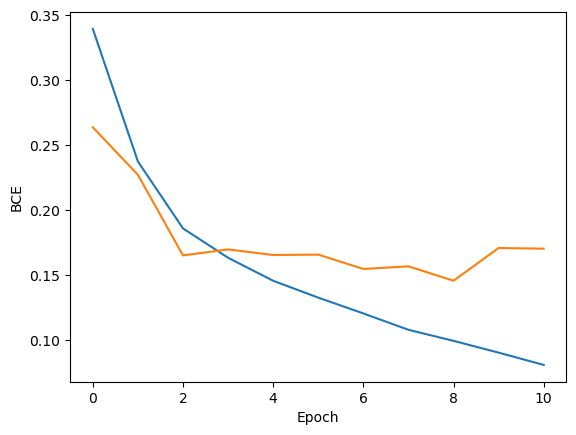

In [30]:
print('Epoch:', epoch)
print('Loss:', min_train_losses[-1])
print('Valid Loss:', min_valid_losses[-1])
plt.plot(min_train_losses)
plt.plot(min_valid_losses)
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.show()

In [31]:
min_valid_loss = 1000
min_valid_losses = None
min_train_losses = None

lrs = [0.001, 0.0005]
dropouts = [0.0, 0.1]

for lr in lrs:
    for dropout in dropouts:

        torch.cuda.empty_cache()

        start = time.time()

        epoch, train_loss, valid_loss, train_losses, valid_losses = runNN(lr, dropout)

        end = time.time()

        total_time = np.round(end - start, 3)

        print('For lr:', lr, 'and dropout:', dropout, 'after', epoch, 
              'epochs:\ntraining loss:', np.round(train_loss, 5), '\nvalidation loss:', 
              np.round(valid_loss, 5), '\nseconds:', total_time, '\n')

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            min_valid_losses = valid_losses
            min_train_losses = train_losses

For lr: 0.001 and dropout: 0.0 after 9 epochs:
training loss: 0.10849 
validation loss: 0.17683 
seconds: 1454.74 

For lr: 0.001 and dropout: 0.1 after 10 epochs:
training loss: 0.1038 
validation loss: 0.21211 
seconds: 1597.107 

For lr: 0.0005 and dropout: 0.0 after 9 epochs:
training loss: 0.08803 
validation loss: 0.16284 
seconds: 1432.544 

For lr: 0.0005 and dropout: 0.1 after 9 epochs:
training loss: 0.09005 
validation loss: 0.17364 
seconds: 1425.162 



Epoch: 9
Loss: 0.08803004053235054
Valid Loss: 0.16283758246898652


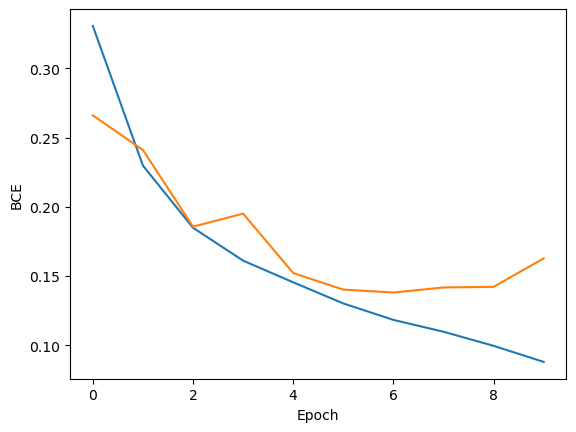

In [32]:
print('Epoch:', epoch)
print('Loss:', min_train_losses[-1])
print('Valid Loss:', min_valid_losses[-1])
plt.plot(min_train_losses)
plt.plot(min_valid_losses)
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.show()

As can be seen, the optimal hyperparameters were a learning rate of 0.0005 and no droupout, resulting in a validation loss of 0.16248. With my VGGNet custom model tuned, I moved on to using a pretrained model. PyTorch provied a number of these models and I decided to use ResNet152. I adjusted the classifier at the end though to fit to a binary classification problem. I also used the optimal hyperparameters arrived at from my VGGNet custom model.

In [19]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.resnet = models.resnet152(weights='DEFAULT')
        
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1)
        )
        
    def forward(self, x):
        return self.resnet(x)

In [20]:
def runResNet(lr):

    torch.cuda.empty_cache()

    model = ResNet().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cost = nn.BCEWithLogitsLoss()
    batch_size = 256
    
    epochs = 50

    train_loader = DataLoader(train, 
                              batch_size=batch_size, 
                              shuffle=True,
                              pin_memory=True)

    valid_loader = DataLoader(valid, 
                              batch_size=batch_size, 
                              shuffle=True,
                              pin_memory=True)

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):

        train_loss = 0.0
        train_count = 0

        valid_loss = 0.0
        valid_count = 0

        model.train()

        for X, y in train_loader:

            optimizer.zero_grad()

            X_count = X.shape[0]

            X, y = X.cuda(), y.cuda()

            pred_y = model(X)

            loss = cost(pred_y.view(-1), y.float())
            train_loss += loss.item() * X_count
            train_count += X_count

            loss.backward()

            optimizer.step()

        model.eval()

        for X, y in valid_loader:

            X_count = X.shape[0]

            X, y = X.cuda(), y.cuda()

            pred_y = model(X)

            loss = cost(pred_y.view(-1), y.float())
            valid_loss += loss.item() * X_count
            valid_count += X_count

        train_loss /= train_count
        valid_loss /= valid_count

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        clear_output(wait=True)
        print('Epoch:', epoch)
        print('Loss:', train_losses[-1])
        print('Valid Loss:', valid_losses[-1])
        plt.plot(train_losses)
        plt.plot(valid_losses)
        plt.ylabel('BCE')
        plt.xlabel('Epoch')
        plt.show()
        
        if epoch > 1 and valid_losses[-1] > valid_losses[-2]:
            break
            
    del train_loader
    del valid_loader
    del X
    del y
                
    return model, epoch, train_loss, valid_loss, train_losses, valid_losses

Epoch: 2
Loss: 0.0515253539737314
Valid Loss: 0.11124859955906868


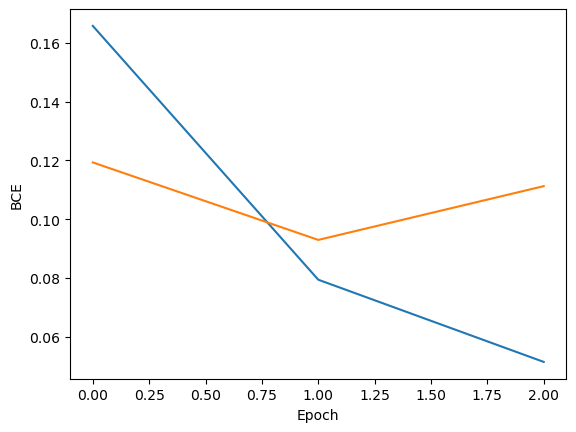

In [21]:
lr = 0.0005
model, epoch, train_loss, valid_loss, train_losses, valid_losses = runResNet(lr)

Finally, it was clear that the ResNet model performed better than my custom VGGNet model. So, I used this model to make predictions on the test set and uploaded it to Kaggle.

In [31]:
test_file_path = 'data/test/'
test_sample = pd.read_csv('data/sample_submission.csv')
test = CustomImageDataset(test_sample, test_file_path, transform=data_transform)
test_loader = DataLoader(test, batch_size=256, shuffle=False, pin_memory=True)

model.eval()

y_preds = []

for X, y in test_loader:
    
    X = X.cuda()
    
    y_pred = list(model(X).cpu().detach().numpy().flatten())
    y_preds.extend(y_pred)
    
test_sample['label'] = y_preds
test_sample['label'] = test_sample['label'].astype('int')
test_sample.to_csv('submission.csv', index=False)

The public score of the ResNet model on Kaggle was 0.8775 and the private score was 0.8497. I feel that these are pretty good scores for the purposes of this assignment. However, I feel like I could do much better and will address that feeling in the conclusion. 

# Conclusion

I think something that really improved the perfomance of my models was using the pretrained models and then tuning them to to provided data. For example, the ResNet model was some 150 layers deep while my VGGNet custom model was around 15. Just to tune the model took me running the models overnight on a fast GPU, so training a 150 layer deep model would have taken much much longer. So, I guess the upshot is that when existing models that have been shown to produce positive results are available, use them.

In the future, some improvements could include exploring other architectures, other hyperparameters, tuning the optimizer and preprocessing the data a bit more. PyTorch provides a great deal of CNN architectures and perhaps ResNet was not the best fit. Additionally, I didn't really modify the classifier portion, which could yield better results.

As for hyperparameters, I think I could have explored more learning rates, especially with the pretrained model. As can be observed, it only ran 3 epochs before early stopping was reached so I feel like decreasing the learning rate would probably have been a good idea. I also didn't explore the batch size as a hyperparameter and the batch size of 256 that I used is pretty large. I also could have taken a more fine grained approach to the dropout hyperparameter. 

As for the optimizer, I only considered Adam and used the default values. I could have explored many others and tuned the optimizer parameters for better results. As for preprocessing the data, all I did was normalize the data. I certainly could have performed some transformation on the data such as rotations and inversions, but I didn't was to increase the size of the dataset too much do to time constraints.